In [1]:
import scanpy as sc
from os import listdir

DPATH = '/home/risitop/Documents/PHD/data/ewing/'

exclusions = ["AB1816885", "MAPPYACT-648", "MAPPYACTS-555", "PDX-3686"]
ewing_10x = {
    file.split(".")[0]: sc.read_h5ad(DPATH + f"preprocessed/{file}") 
    for file in listdir(DPATH + "preprocessed/") if file.split(".")[0] not in exclusions
}

# We convert it to List[AnnData] as we do not 
# care about label here
datasets = list(ewing_10x.values())

In [65]:
import numpy as np

def annotate_ics(adata, gene_set, label):
    selected = adata.var_names.intersection(gene_set)
    if len(selected) == 0:
        adata.obs[label] = 0.0
        return
    adata.obs[label] = adata[:, selected].X.mean(axis=1)
    adata.obs[label] -= adata.obs[label].mean()
    adata.obs[label] /= adata.obs[label].std()
     
all_signatures = {}
with open(DPATH + "ics_and_signatures.gmt", encoding="latin-1") as fin:
    for row in fin:
        elements = row.split("\t")
        all_signatures[elements[0]] = elements[2:-1]
        
ics = [
    ('IC1+', 'G2/M'),
    ('IC2+', 'G1/S'),
    ('IC4+', 'MT'),
    ('IC6+', 'Cell respiration'),
    ('IC9+', 'RNA splicing'),
    ('IC10+', 'EWS-FLI1 targets'),
    ('IC14+', 'Hypoxia')
]
for adata in datasets:
    for key, label in ics:
        annotate_ics(adata, all_signatures[key], label)
    guesses = [""]*adata.n_obs
    for i in range(adata.n_obs):
        guess_pheno, score = None, -np.inf
        for _, pheno in ics:
            pscore = adata.obs[pheno][i]
            if pscore > score:
                score = pscore
                guess_pheno = pheno
        guesses[i] = guess_pheno
    adata.obs['phenotype'] = guesses

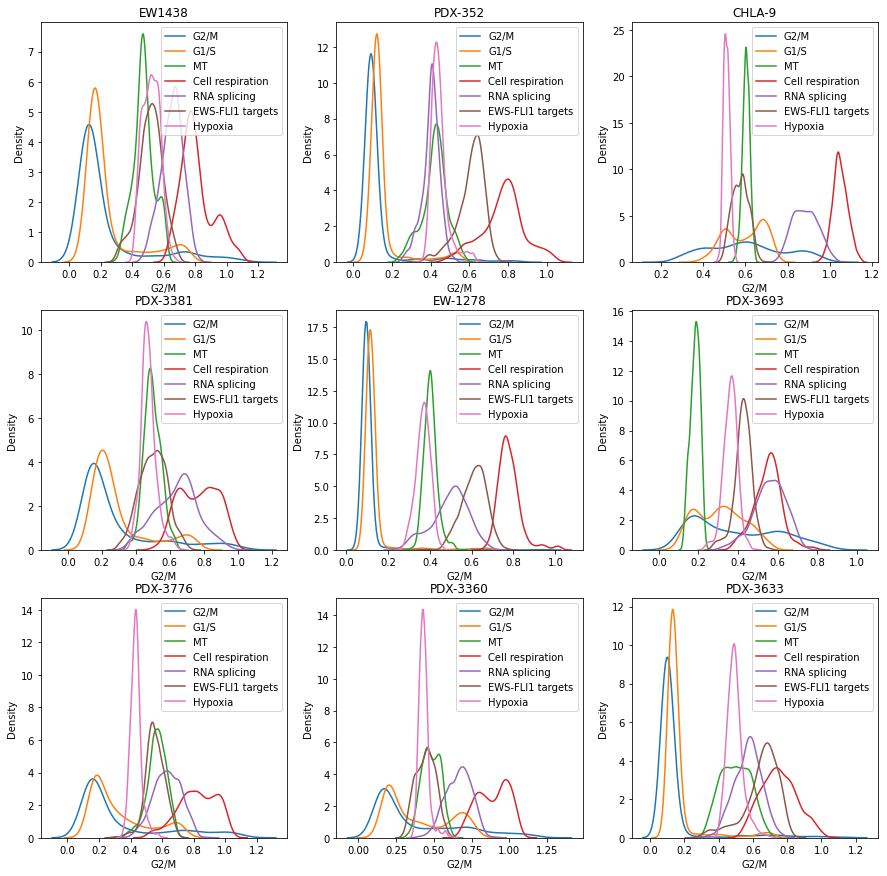

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i, (keyd, adata) in enumerate(ewing_10x.items()):
    df = adata.obs[[key for _, key in ics]]

    plt.subplot(3,3,i+1)
    for key in df.columns:
        sns.kdeplot(df[key], label=key)

    plt.legend()
    plt.title(keyd)

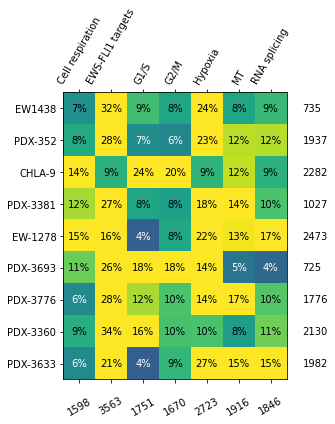

In [66]:
from transmorph.utils.plotting import plot_label_distribution_heatmap

plot_label_distribution_heatmap(datasets, label="phenotype", dataset_keys=ewing_10x.keys())

In [7]:
from transmorph.utils.plotting import scatter_plot, reduce_dimension

reduce_dimension(datasets, output_obsm="raw", reducer="umap")

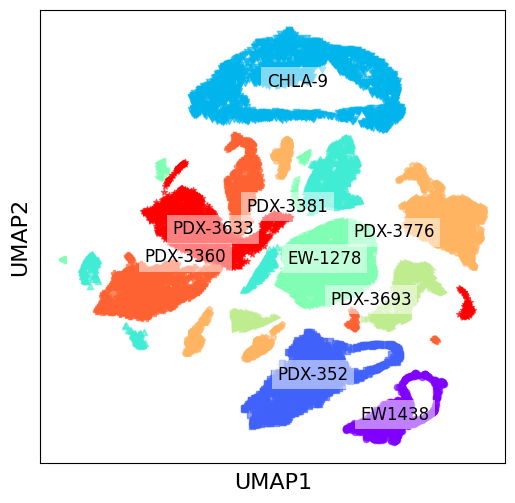

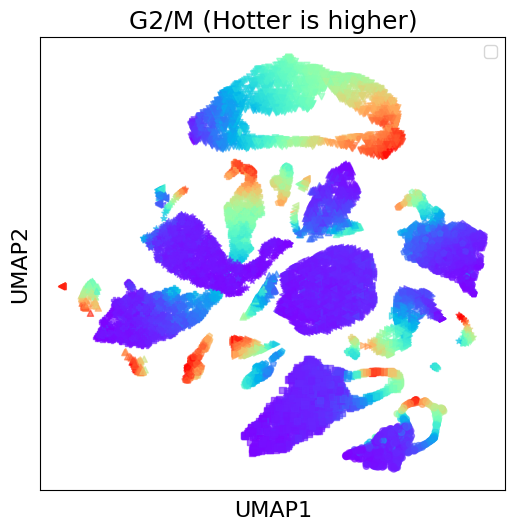

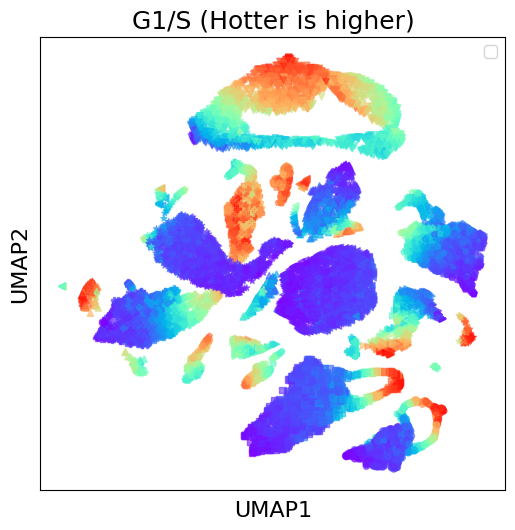

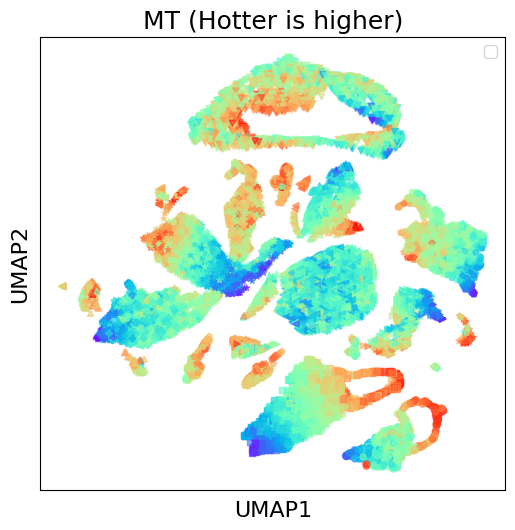

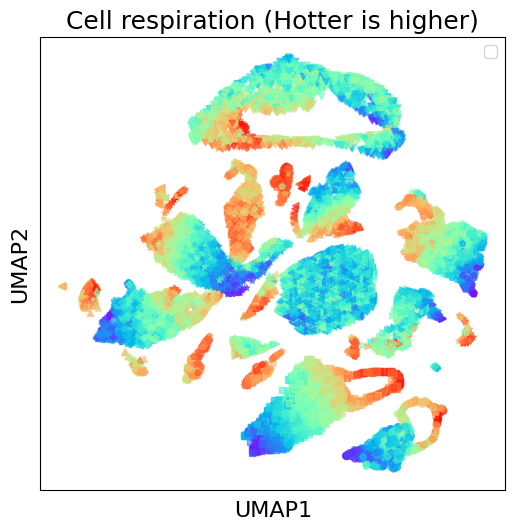

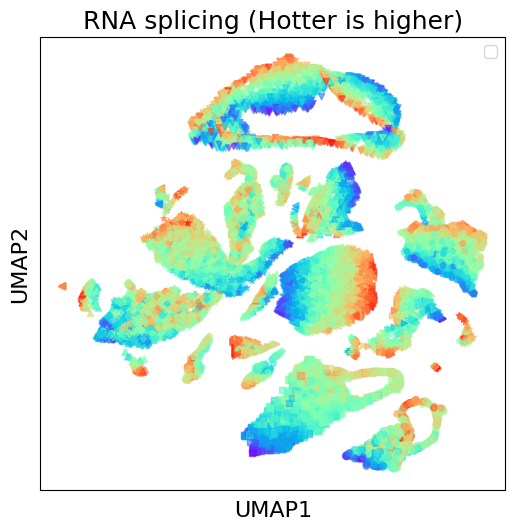

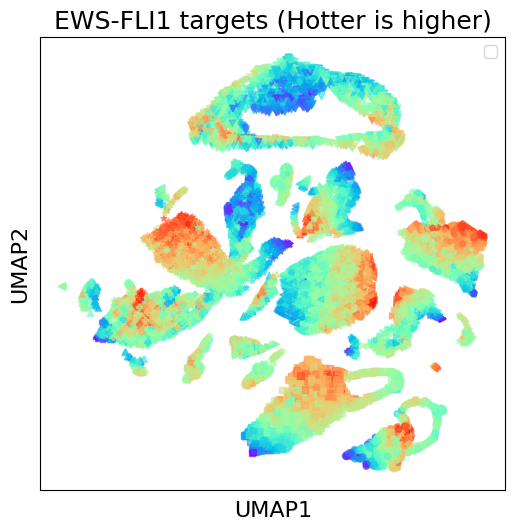

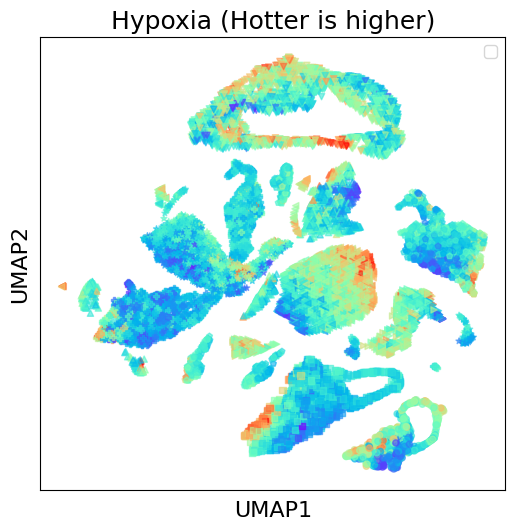

In [61]:
scatter_plot(
    datasets, 
    input_obsm="raw", 
    plot_cluster_names=True, 
    show_legend=False, 
    cluster_names=list(ewing_10x.keys())
)
for _, key in ics:
    scatter_plot(
        datasets, 
        input_obsm="raw", 
        color_by=key,
        title=f"{key} (Hotter is higher)"
    )

In [48]:
from transmorph.models import EmbedMNN

model = EmbedMNN(embedding_optimizer="mde", embedding_n_neighbors=10)
model.fit(datasets)

EMBED_MNN > Transmorph model is initializing.
EMBED_MNN > Ready to start the integration of 9 datasets, 15067 total samples.
EMBED_MNN > Running layer LAYER_INPUT#85.
EMBED_MNN > Running layer LAYER_TRANSFORMATION#86.
EMBED_MNN > Running layer LAYER_MATCHING#87.
LAYER_MATCHING#87 > Calling matching MATCHING_MNN.
EMBED_MNN > Running layer LAYER_MERGING#88.
LAYER_MERGING#88 > Running merging MERGING_GRAPH_EMBEDDING...
EMBED_MNN > Running layer LAYER_OUTPUT#89.
EMBED_MNN > Terminated. Total embedding shape: (15067, 2)


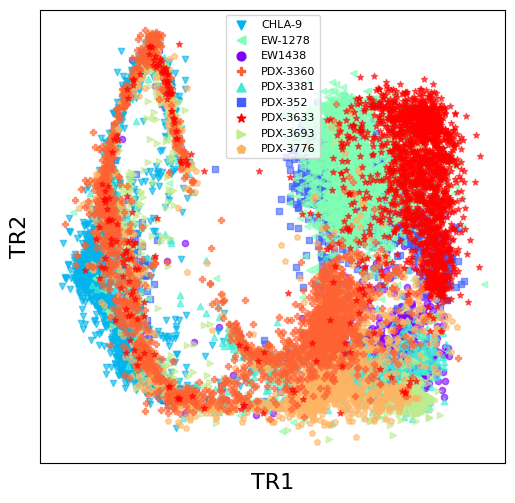

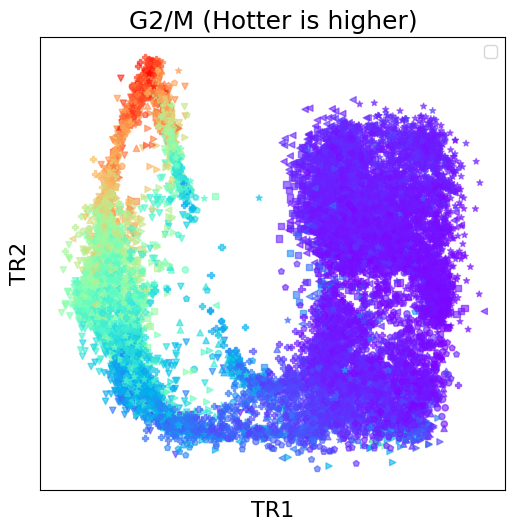

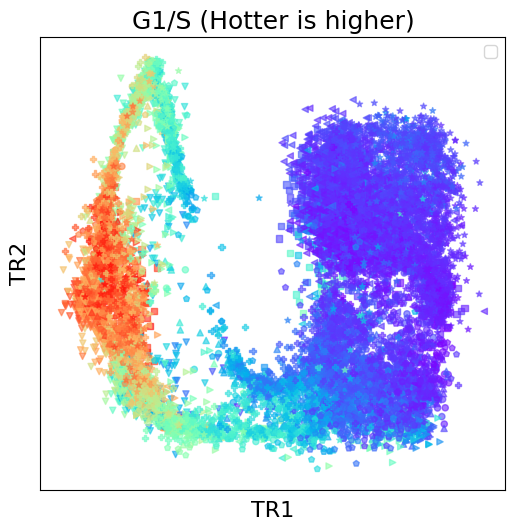

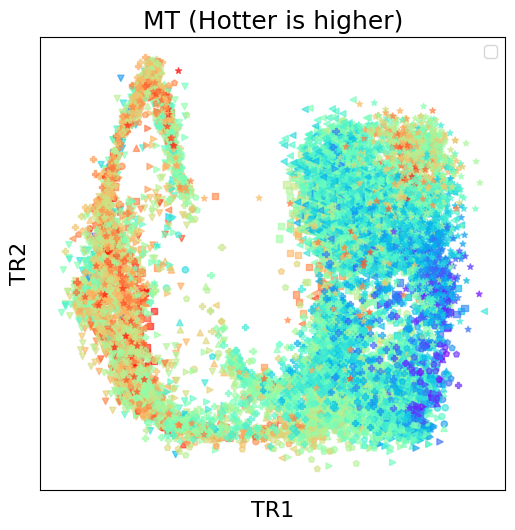

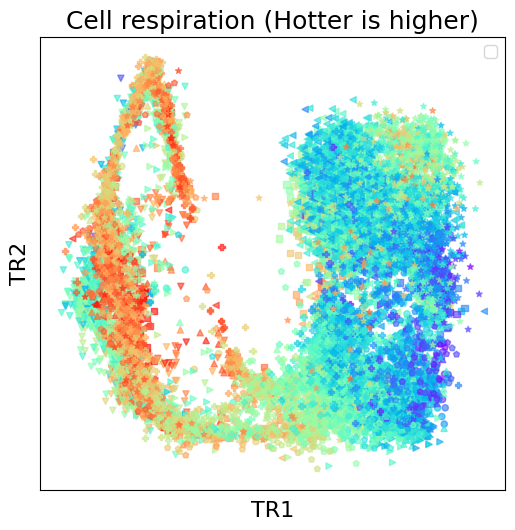

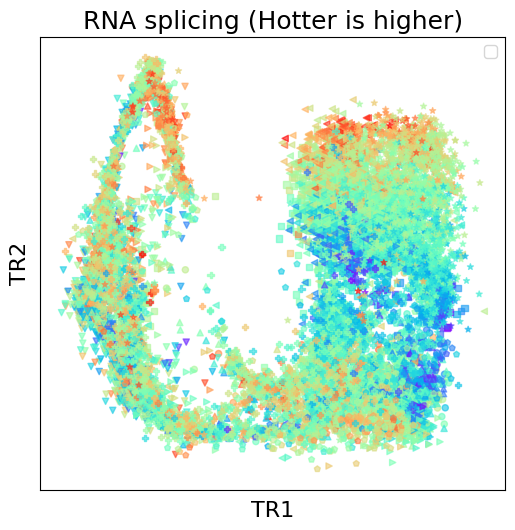

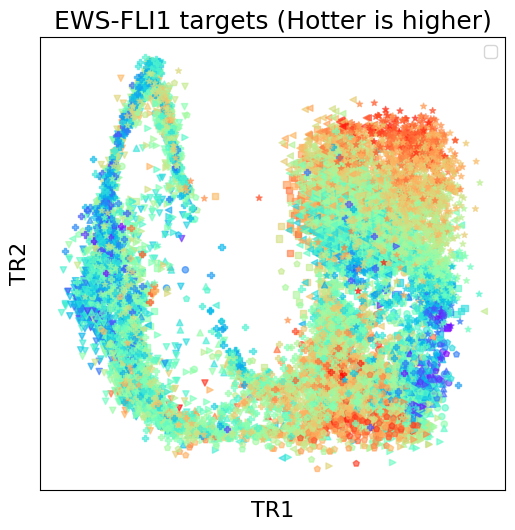

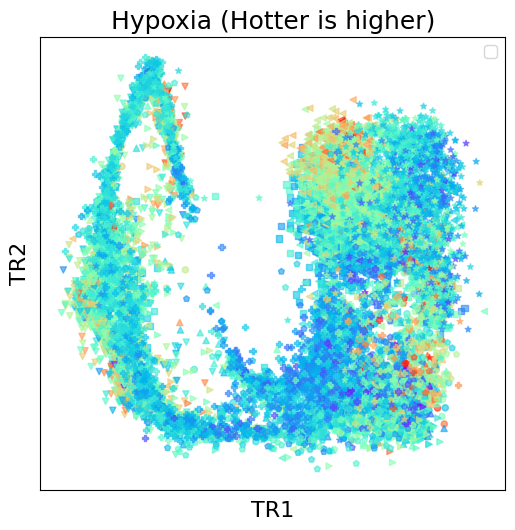

In [60]:
scatter_plot(
    datasets, 
    input_obsm="transmorph", 
    cluster_names=list(ewing_10x.keys()),
    xlabel="TR1",
    ylabel="TR2"
)

for _, key in ics:
    scatter_plot(
        datasets, 
        input_obsm="transmorph", 
        color_by=key,
        xlabel="TR1",
        ylabel="TR2",
        title=f"{key} (Hotter is higher)"
    )

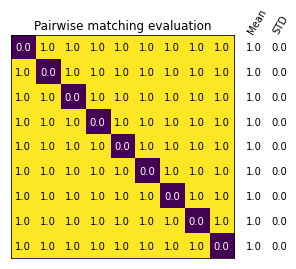

In [32]:
from transmorph.utils.plotting import plot_matching_eval

plot_matching_eval(model, datasets, obs="phenotype")